All combined

/Users/iaamir/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


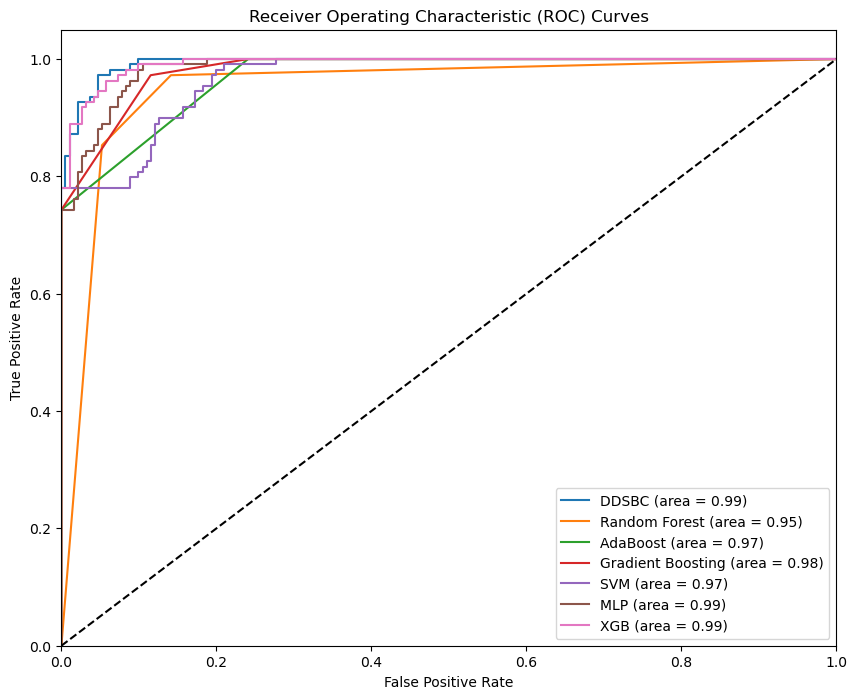

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Your preprocessing code (loading data, feature encoding, splitting, etc.) goes here
# Load datasets
dataseta = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/b3.csv')
datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')


# Ensure 'cell' columns are of the same data type in both datasets
dataseta['cell'] = dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Align datasets by 'cell'
# Inner join ensures only matching rows are kept
combined_dataset = pd.merge(dataseta, datasetb, on='cell')

# Define the enhanced SMILES encoding function correctly
def enhanced_encode_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol),
                Descriptors.NumRotatableBonds(mol), AllChem.CalcTPSA(mol), len(mol.GetRingInfo().AtomRings())]
    else:
        return [0] * 7

# Apply enhanced SMILES encoding to the combined dataset
combined_dataset['drug1_features'] = combined_dataset['drug1'].apply(enhanced_encode_smiles)
combined_dataset['drug2_features'] = combined_dataset['drug2'].apply(enhanced_encode_smiles)

# Process the features and PCA as before
features_combined = pd.DataFrame(np.concatenate((combined_dataset['drug1_features'].tolist(), combined_dataset['drug2_features'].tolist()), axis=1),
                                  columns=['MolWt1', 'MolLogP1', 'NumHAcceptors1', 'NumHDonors1', 'NumRotatableBonds1', 'TPSA1', 'RingCount1',
                                           'MolWt2', 'MolLogP2', 'NumHAcceptors2', 'NumHDonors2', 'NumRotatableBonds2', 'TPSA2', 'RingCount2'])

# Assuming the 'label' column is in 'dataseta', adjust if it's otherwise
y = combined_dataset['label'].values

# Normalize and PCA on gene expression data
scaler = StandardScaler()
gene_expression_data = combined_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])  # Adjust as necessary to drop non-gene expression columns
gene_expression_scaled = scaler.fit_transform(gene_expression_data)
pca = PCA(n_components=0.95)
gene_expression_pca = pca.fit_transform(gene_expression_scaled)

# Combine PCA components with molecular features
X = np.concatenate([gene_expression_pca, features_combined.values], axis=1)
y = dataseta['label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)


# Define base learners and meta-learner for stacking model
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=250, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=250, random_state=42))
]

meta_learner = LogisticRegression(random_state=42)
ddsbc = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5, n_jobs=-1)

# Define other classifiers for comparison
classifiers = {
    "DDSBC": ddsbc,  # Your ensemble stacking classifier named DDSBC
    "Random Forest": RandomForestClassifier(n_estimators=2,random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=2, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=2, random_state=42),
    "SVM": SVC(probability=True, random_state=2),
    "MLP": MLPClassifier(random_state=1),
    "XGB": XGBClassifier(min_child_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=10)
}

# Prepare to plot ROC curves
plt.figure(figsize=(10, 8))

# Loop through classifiers to train, predict, and calculate ROC
for name, clf in classifiers.items():
    # Train the model
    clf.fit(X_smote, y_smote)
    
    # Predict probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Dictionary to store metrics
metrics_dict = {
    'Accuracy': accuracy_score, 
    'F1-Score': f1_score, 
    'Precision': precision_score,
    'Recall': recall_score,
    'ROC AUC': roc_auc_score
}

# Loop through classifiers to train, predict, and calculate metrics
for metric_name, metric_func in metrics_dict.items():
    print(f"{metric_name}:")
    for name, clf in classifiers.items():
        # Train the model
        clf.fit(X_smote, y_smote)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Calculate metric
        if metric_name == 'ROC AUC':
            y_proba = clf.predict_proba(X_test)[:, 1]
            metric = metric_func(y_test, y_proba)
        else:
            metric = metric_func(y_test, y_pred)
        
        # Print metric
        print(f"\t{name}: {metric:.2f}")
    
    print()  # Add a line break between different metrics


Accuracy:
	DDSBC: 0.95
	Random Forest: 0.91
	AdaBoost: 0.91
	Gradient Boosting: 0.92
	SVM: 0.87
	MLP: 0.92
	XGB: 0.94

F1-Score:
	DDSBC: 0.93
	Random Forest: 0.88
	AdaBoost: 0.85
	Gradient Boosting: 0.89
	SVM: 0.81
	MLP: 0.90
	XGB: 0.93

Precision:
	DDSBC: 0.93
	Random Forest: 0.90
	AdaBoost: 1.00
	Gradient Boosting: 0.83
	SVM: 0.82
	MLP: 0.88
	XGB: 0.89

Recall:
	DDSBC: 0.94
	Random Forest: 0.85
	AdaBoost: 0.74
	Gradient Boosting: 0.97
	SVM: 0.81
	MLP: 0.92
	XGB: 0.96

ROC AUC:
	DDSBC: 0.99
	Random Forest: 0.95
	AdaBoost: 0.97
	Gradient Boosting: 0.98
	SVM: 0.97
	MLP: 0.99
	XGB: 0.99



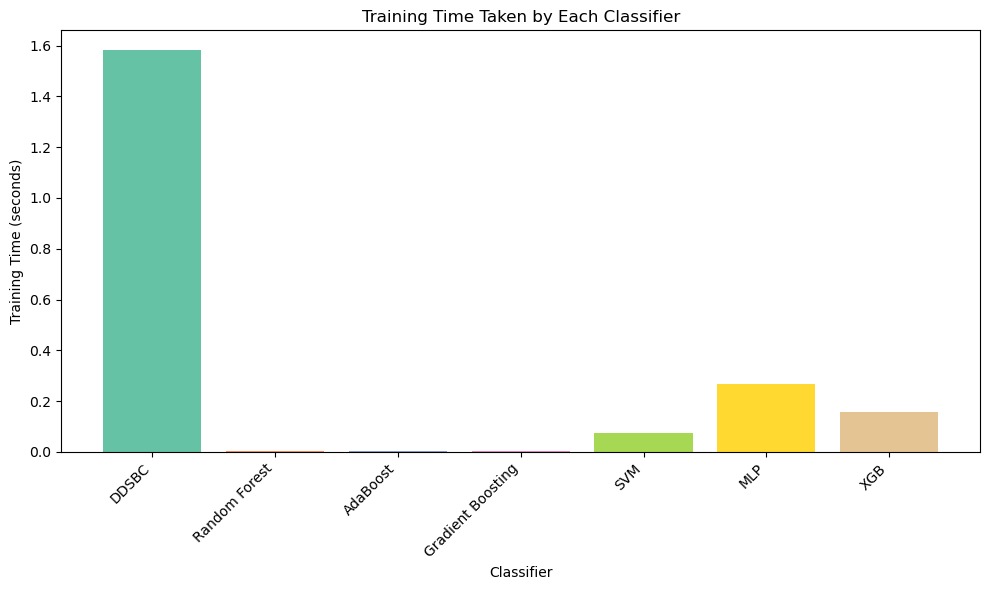

Training times (in seconds):
DDSBC: 1.58 seconds
Random Forest: 0.00 seconds
AdaBoost: 0.00 seconds
Gradient Boosting: 0.00 seconds
SVM: 0.07 seconds
MLP: 0.27 seconds
XGB: 0.16 seconds


In [5]:
# Plot the training times
plt.figure(figsize=(10, 6))
plt.bar(training_times.keys(), training_times.values(), color=plt.cm.Set2(range(len(training_times))))
plt.xlabel('Classifier')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Taken by Each Classifier')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Print the training times for reference
print("Training times (in seconds):")
for name, time_taken in training_times.items():
    print(f"{name}: {time_taken:.2f} seconds")
